# Google Colab에서 코드실행

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 필요한 라이브러리 다운로드

In [ ]:
pip install transformers

In [ ]:
pip install soynlp emoji

In [ ]:
pip install git+https://github.com/haven-jeon/PyKoSpacing.git

## 데이터 불러오기

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModelWithLMHead
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:", device)

filename = '/content/drive/My Drive/shop_comment/data_train.csv'
data_train = pd.read_csv(filename)

filename = '/content/drive/My Drive/shop_comment/data_test.csv'
data_test = pd.read_csv(filename)

device: cuda:0


## 데이터 preprocess



**더미 데이터**

실제 train 데이터 내부 이상치를 clean_dummy 함수로 제거

또한 pykospacing으로 전처리 추가로 진행

ex) 굿 ㅂㄷㄳㅂㄽㅅ -> 굿


In [ ]:
text1 = "굿 ㅂㄷ귿ㄱㅅㄱㄷㄱㅅㄱㅇㄱㅈㄷ븐ㅂㅅㄱㄷㄱㄴㄱㄷ긔닌ㄱ늑ㄷㄱㅅㄱㄷㄱㅅㅋㅌㄱㅅㄱㅌㄱㅅㄱㄷㄱㄷㄱㅈㄷㄱㄷㄱ"
text2 = "ㅂㄷ귿ㄱㅅㄱㄷㄱㅅㄱㅇㄱㅈㄷ븐ㅂㅅㄱㄷㄱㄴㄱㄷ긔닌ㄱ늑ㄷㄱㅅㄱㄷㄱㅅㅋㅌㄱㅅㄱㅌㄱㅅㄱㄷㄱㄷㄱㅈㄷㄱㄷㄱ"
text3 = "ㅠㅠ쭈굴어듬이이이ㅣㅇ "
text4 = "콘크리트벽에 박는 부속 칼블럭좀 보내달라 했는데 안본내 주셧어요 ㅠ"
text5 = "별루 ㅏㅛㅇ치ㅗ티ㅓ치ㅗ탛캏타ㅗ티ㅗ티ㅗ티ㅛ티ㅛ티ㅗㅗㅗ치ㅕ치ㅕ쳐ㅣ처ㅣ치ㅓ처ㅣ펴ㅣ쳐ㅣ치ㅕㅐㅛㅌ쵸ㅔ려ㅔㅎ"
text6 = "진짜별로 산지 한달 넘었는데 썩은내 대박 진짜 짜증나서 갖다버림 어다니우나우아우러나으어ㅏ누아우우어아유어으로ㅜ텅너ㅓㅇ류너ㅡㅡ 1235"

In [ ]:
import re
import emoji
from soynlp.normalizer import repeat_normalize
from pykospacing import Spacing #for data spacing


pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

def clean(x):
    x = pattern.sub(' ', x)
    x = url_pattern.sub('', x)
    x = x.strip()
    x = repeat_normalize(x, num_repeats=2)

    spacing
    
    spacing = Spacing()
    x = spacing(x)
    return x

def clean_dummy(x):
  txt_list = x.split()
  for _ in range(0, len(txt_list)):
    txt_length = len(txt_list[-1])
    dummy_length = 0
    for xstr in txt_list[-1]:
      if bool(re.search('[ㄱ-ㅊㅌ-ㅍㅏ-ㅛㅡ-ㅣ 0-9()@:%_\+.~#?&//=-]', xstr)):
        dummy_length += 1
    if dummy_length >= 2 or txt_length == 1:
      txt_list.pop()
    else:
      break
  if len(txt_list) == 0:
    return "NAN"
  else:
    return " ".join(txt_list)

data_train["reviews"] = data_train["reviews"].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
data_test["reviews"] = data_test["reviews"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")

data_train["reviews"] = data_train["reviews"].apply(clean)
data_test["reviews"] = data_test["reviews"].apply(clean) 

data_train["reviews"] = data_train["reviews"].apply(clean_dummy)
data_test["reviews"] = data_test["reviews"].apply(clean_dummy) 

#save data

#data_train.to_csv("/content/drive/My Drive/shop_comment/data_train_spaced_cleaned.csv", index=False)
#data_test.to_csv("/content/drive/My Drive/shop_comment/data_test_spaced_cleaned.csv", index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning: The default value of regex will change from True to False in a future version.


In [ ]:
data_train.head(5)

,id,reviews,target
0,0,조아 요 처음 구입 싸게 햇어요,2
1,1,생각보다 잘 안 돼요 매지 바른지 하루밖에 안 됐는데 ㅠㅠ 25천원 가량 주고 사기...,1
2,2,디자인은 괜찮은데 상품이 금이 가서 교환했는데 두 번째 받은 상품도 까져 있고 안쪽...,2
3,3,기 전에 이 제품 말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다 ...,2
4,4,튼튼하고 손목을 잘 받쳐주네요,5


In [ ]:
data_test.head(5)

,id,reviews
0,0,채소가 약간 시 들어 있어요
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이 없어서 들어 올...
2,2,부들부들 좋네요 입어 보고 시원하면 또 살게요
3,3,이런 1 8 골드 주라니깐 파란 개 오네 회사 전화 걸어도 받지도 않고 머하자는 거임
4,4,검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별 하나도 아까워요


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       25000 non-null  int64 
 1   reviews  25000 non-null  object
 2   target   25000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 586.1+ KB


### 문서 최대길이 추출

In [ ]:
maxlen = 0
for i in range(data_train.shape[0]):
  if len(data_train["reviews"].iloc[i]) > maxlen:
    maxlen = len(data_train["reviews"].iloc[i])
  if len(data_test["reviews"].iloc[i]) > maxlen:
    maxlen = len(data_test["reviews"].iloc[i])
print("문서 최대길이", maxlen)

문서 최대길이 171


### 데이터 타입 확인
imbalance한 데이터임을 알 수 있습니다.

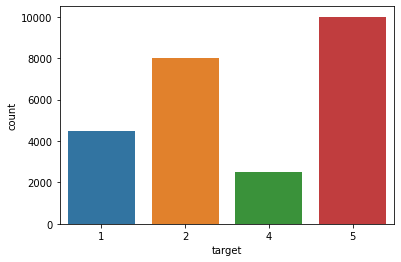

In [ ]:
sns.countplot(data=data_train, x='target')

In [ ]:
data_train["target"].value_counts()

5    10000
2     8000
1     4500
4     2500
Name: target, dtype: int64

## 데이터 토큰화
우선 review의 대부분이 구어체와, 댓글 형식으로 작성되어 있습니다.

따라서 구어체, 댓글 위주로 학습된 모델인 kcElectra를 사용했습니다.

In [ ]:
MODEL_NAME = "beomi/KcELECTRA-base" #"klue/roberta-large" #beomi/kcbert-large" #"beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
data_train_X = data_train["reviews"]
data_train_y = data_train["target"]

### dataset 정의

In [ ]:
class ReviewDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

In [ ]:
class ReviewTestDataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings

  def __getitem__(self, idx):
    item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
    return item
  
  def __len__(self):
    return 25000

### FocalLoss
target imbalance 문제 해결을 위한 loss function으로 focal loss를 사용하고, 강한 gamma값을 사용했습니다.

https://gist.github.com/f1recracker/0f564fd48f15a58f4b92b3eb3879149b

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.CrossEntropyLoss):
    ''' Focal loss for classification tasks on imbalanced datasets '''

    def __init__(self, gamma=6, alpha=None, ignore_index=0, reduction='none'):
        super().__init__(weight=alpha, ignore_index=ignore_index, reduction='none')
        self.reduction = reduction
        self.gamma = gamma

    def forward(self, input_, target):
        cross_entropy = super().forward(input_, target)
        # Temporarily mask out ignore index to '0' for valid gather-indices input.
        # This won't contribute final loss as the cross_entropy contribution
        # for these would be zero.
        target = target * (target != self.ignore_index).long()
        input_prob = torch.gather(F.softmax(input_, 1), 1, target.unsqueeze(1))
        loss = torch.pow(1 - input_prob, self.gamma) * cross_entropy
        return torch.mean(loss)

In [ ]:
from torch import nn
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = FocalLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

### 모델 학습 args
train시 batch size를 바꿔가며 학습했습니다.

In [ ]:
training_args = TrainingArguments(
    output_dir="./",
    num_train_epochs=2,
    per_device_train_batch_size=14,
    per_device_eval_batch_size=32,
    optim = "adamw_torch",
    logging_strategy='epoch',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    metric_for_best_model='accuracy',
    greater_is_better=True,
    load_best_model_at_end=True,
    seed = 42,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  accuracy = accuracy_score(labels, preds)
  return {
      "accuracy": accuracy
  }

## 모델 학습
huggingface를 사용해서 학습을 진행했습니다.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True) #총 5번의 fold 진행
n = 0 #x번째 fold인지 기록

fold_target_pred = []

for train_index, valid_index in skf.split(data_train_X, data_train_y):
  # split data
  train_X = np.array(data_train_X)
  train_Y = np.array(data_train_y)
  
  X_train, X_valid = train_X[train_index], train_X[valid_index]
  y_train, y_valid = train_Y[train_index], train_Y[valid_index]

  '''
  print(X_train.shape)
  # add data (target이 4인 소수 data random oversampling)
  X_add = []
  y_add = []
  for idx in range(X_train.shape[0]):
    if int(y_train[idx]) == 4:
      X_add.append(X_train[idx])
      y_add.append(y_train[idx])

  X_train = np.append(X_train, np.array(X_add), axis = 0)
  y_train = np.append(y_train, np.array(y_add), axis = 0)

  ### Mix Data Again ####
  X_train, y_train = shuffle(X_train, y_train, random_state=42)

  print(X_train.shape)
  '''

  # data tokenizer

  # train data
  tokenized_train_sentences = tokenizer(
    X_train.tolist(),
    return_tensors="pt",
    max_length=maxlen,
    padding=True,
    truncation=True,
    add_special_tokens=True,
  )

  # valid data
  tokenized_valid_sentences = tokenizer(
    X_valid.tolist(),
    return_tensors="pt",
    max_length=maxlen,
    padding=True,
    truncation=True,
    add_special_tokens=True,
  )

  # test data
  tokenized_test_sentences = tokenizer(
    list(data_test["reviews"]),
    return_tensors="pt",
    max_length=maxlen,
    padding=True,
    truncation=True,
    add_special_tokens=True,
  )

  train_dataset = ReviewDataset(tokenized_train_sentences, y_train)
  valid_dataset = ReviewDataset(tokenized_valid_sentences, y_valid)

  model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=6)
  model.to(device)

  trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = valid_dataset,
    compute_metrics = compute_metrics,
  )

  trainer.train()
  test_dataset = ReviewTestDataset(tokenized_test_sentences)
  outputs = trainer.predict(test_dataset)
  fold_target_pred.append(outputs)

loading configuration file https://huggingface.co/beomi/KcELECTRA-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/61dd2bdbb7e56ff51fdc66b6f0d1973d2d806cd616d38a149f1bfd2753babc3c.ba488f0d9624511a98ed83af3e8f6b33fe20b502e2cfb16ee9858a6b6f521982
Model config ElectraConfig {
  "_name_or_path": "beomi/KcELECTRA-base",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_atten

Epoch,Training Loss,Validation Loss,Accuracy
1,0.236800,0.176775,0.701800
2,0.151400,0.171359,0.699600


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
Saving model checkpoint to ./checkpoint-1429
Configuration saved in ./checkpoint-1429/config.json
Model weights saved in ./checkpoint-1429/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
Saving model checkpoint to ./checkpoint-2858
Configuration saved in ./checkpoint-2858/config.json
Model weights saved in ./checkpoint-2858/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./checkpoint-1429 (score: 0.7018).
***** Running Prediction *****
  Num examples = 25000
  Batch size = 32


loading configuration file https://huggingface.co/beomi/KcELECTRA-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/61dd2bdbb7e56ff51fdc66b6f0d1973d2d806cd616d38a149f1bfd2753babc3c.ba488f0d9624511a98ed83af3e8f6b33fe20b502e2cfb16ee9858a6b6f521982
Model config ElectraConfig {
  "_name_or_path": "beomi/KcELECTRA-base",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_atten

Epoch,Training Loss,Validation Loss,Accuracy
1,0.238800,0.187062,0.679400
2,0.149600,0.177606,0.699200


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
Saving model checkpoint to ./checkpoint-1429
Configuration saved in ./checkpoint-1429/config.json
Model weights saved in ./checkpoint-1429/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
Saving model checkpoint to ./checkpoint-2858
Configuration saved in ./checkpoint-2858/config.json
Model weights saved in ./checkpoint-2858/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./checkpoint-2858 (score: 0.6992).
***** Running Prediction *****
  Num examples = 25000
  Batch size = 32


loading configuration file https://huggingface.co/beomi/KcELECTRA-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/61dd2bdbb7e56ff51fdc66b6f0d1973d2d806cd616d38a149f1bfd2753babc3c.ba488f0d9624511a98ed83af3e8f6b33fe20b502e2cfb16ee9858a6b6f521982
Model config ElectraConfig {
  "_name_or_path": "beomi/KcELECTRA-base",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_atten

Epoch,Training Loss,Validation Loss,Accuracy
1,0.238300,0.194652,0.687200
2,0.150100,0.178795,0.697000


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
Saving model checkpoint to ./checkpoint-1429
Configuration saved in ./checkpoint-1429/config.json
Model weights saved in ./checkpoint-1429/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
Saving model checkpoint to ./checkpoint-2858
Configuration saved in ./checkpoint-2858/config.json
Model weights saved in ./checkpoint-2858/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./checkpoint-2858 (score: 0.697).
***** Running Prediction *****
  Num examples = 25000
  Batch size = 32


loading configuration file https://huggingface.co/beomi/KcELECTRA-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/61dd2bdbb7e56ff51fdc66b6f0d1973d2d806cd616d38a149f1bfd2753babc3c.ba488f0d9624511a98ed83af3e8f6b33fe20b502e2cfb16ee9858a6b6f521982
Model config ElectraConfig {
  "_name_or_path": "beomi/KcELECTRA-base",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_atten

Epoch,Training Loss,Validation Loss,Accuracy
1,0.241700,0.189410,0.685000
2,0.150200,0.179402,0.696800


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
Saving model checkpoint to ./checkpoint-1429
Configuration saved in ./checkpoint-1429/config.json
Model weights saved in ./checkpoint-1429/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
Saving model checkpoint to ./checkpoint-2858
Configuration saved in ./checkpoint-2858/config.json
Model weights saved in ./checkpoint-2858/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./checkpoint-2858 (score: 0.6968).
***** Running Prediction *****
  Num examples = 25000
  Batch size = 32


loading configuration file https://huggingface.co/beomi/KcELECTRA-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/61dd2bdbb7e56ff51fdc66b6f0d1973d2d806cd616d38a149f1bfd2753babc3c.ba488f0d9624511a98ed83af3e8f6b33fe20b502e2cfb16ee9858a6b6f521982
Model config ElectraConfig {
  "_name_or_path": "beomi/KcELECTRA-base",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_atten

Epoch,Training Loss,Validation Loss,Accuracy
1,0.236500,0.187896,0.694600
2,0.148400,0.185064,0.692000


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
Saving model checkpoint to ./checkpoint-1429
Configuration saved in ./checkpoint-1429/config.json
Model weights saved in ./checkpoint-1429/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
Saving model checkpoint to ./checkpoint-2858
Configuration saved in ./checkpoint-2858/config.json
Model weights saved in ./checkpoint-2858/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./checkpoint-1429 (score: 0.6946).
***** Running Prediction *****
  Num examples = 25000
  Batch size = 32


## 제출

In [ ]:
final_pred = np.array(fold_target_pred[0].predictions)

for i in range(1, 5):
  final_pred += fold_target_pred[i].predictions

final_pred = final_pred/5

In [ ]:
filename = '/content/drive/My Drive/shop_comment/sample_submission.csv'
data_sub = pd.read_csv(filename)
data_sub['target'] = np.argmax(final_pred, axis=-1)

In [ ]:
data_sub.head(10)

,id,target
0,0,2
1,1,1
2,2,5
3,3,1
4,4,1
5,5,2
6,6,2
7,7,2
8,8,5
9,9,5


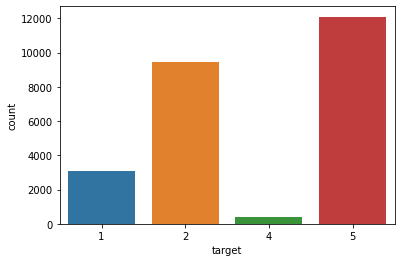

In [ ]:
sns.countplot(data=data_sub, x='target')

In [ ]:
data_sub.to_csv('/content/drive/My Drive/shop_comment/KcELECTRA-space-dummy-gamma6-index0-batch14-sub9.csv', index=False)